---
title: "Theory of RL IV: Monte Carlo Methods"
date: "2021-05-06"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

From now on, we no longer assume complete knowledge of the environment. But how can we evaluate and improve policies without full access to the MDP? In this post, we'll look at Monte Carlo (MC) methods which **only require episodes of experience**, that is, sample trajectories of states, actions, and rewards obtained from interaction with the environment. The key idea underlying MC methods is simply to **approximate the expected return by computing the mean observed return of sample episodes**. Accordingly, MC methods are only defined for episodic tasks since they need well-defined, complete returns.

Below, we'll first discuss how MC methods solve the prediction problem, and then move on to the control problem. 

In [1]:
import numpy as np
import matplotlib as plt
from itertools import count
import gym
import gym_walk

## Monte Carlo Prediction

### Monte Carlo Estimation of State Values

MC prediction of the state-value function of a given policy is pretty straightforward. Recall that the value of a state $s$ under policy $\pi$, $v_{\pi}(s)$, is the expected return starting from that state. MC methods estimate $v_{\pi}(s)$ by simply averaging the returns observed in sample episodes after visits to that state. That is, we sample complete episodes $S_t, A_t, R_{t+1}, S_{t+1}, \dots, R_T, S_T \sim \pi$, calculate the return $G_t$ for all states encountered and finally estimate the value function by averaging the returns obtained from each state $s$. By the law of large numbers, this empirical mean converges to the expected value of $s$ as the number of visits to $s$ goes to infinity.

Since $s$ may be visited multiple times in the same episode, we can define two slightly different algorithms: **first-visit MC prediction** (also called first-visit MC policy evaluation) which estimates $v_{\pi}(s)$ by averaging only the returns following first visits to $s$, and **every-visit MC prediction** (every-visit MC policy evaluation) which averages the returns following all visits to state $s$.

A naive implementation of first-visit MC prediction should make the idea clear. For each state $s$ we could keep a counter $N(S_t)$ and the total observed return $T(S_t)$, both persisting over all sampled episodes. *At the first time step* $t$ that state $S_t$ is visited in an episode, we increment the counter by $1$ and the total return by the observed return $G_t$:
$$N(S_t) \leftarrow N(S_t) + 1$$
$$T(S_t) \leftarrow T(S_t) + G_t$$
Then, we can estimate the value $V(s)$ by computing the mean return:
$$V(S_t) = \dfrac{T(S_t)}{N(S_t)}$$

By the law of large numbers, $V(s) \rightarrow v_{\pi}(s)$ as $N(s) \rightarrow \infty$. The implementation of every-visit MC prediction is nearly equivalent, we simply increment the counter and the total return *every time* $s$ is visited in an episode instead.

However, this computation is of course quite inefficient. What we can do instead is **update the value estimates incrementally after each episode** which is equivalent:

$$V(S_t) \leftarrow V(S_t) + \dfrac{1}{N(S_t)}(G_t - V(S_t)),$$

where $G_t$ is called the **MC target** and $(G_t - V(S_t))$ the **MC error**. Intuitively, after each sampled episode we improve our estimate of the value function by taking a small step in the direction of the observed target.

Note that in non-stationary problems we might prefer to track a running mean by using a constant step-size $\alpha$. This allows us to "forget" old episodes:

$$V(S_t) \leftarrow V(S_t) + \alpha (G_t - V(S_t))$$

In [2]:
def decay(decay_ratio, start_val, min_val, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (start_val - min_val) * values + min_val
    values = np.pad(values, (0, max_steps - decay_steps), 'edge')
    return values

In [28]:
def sample_trajectory(env, pi, max_steps=200):
    done = False
    trajectory = []
    
    while not done:
        state = env.reset()
        
        for t in count():
            action = pi[state]
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    
    return np.array(trajectory, dtype="object")

In [29]:
#| code-fold: show

def mc_prediction(env, pi, gamma=1., n_episodes=1000, max_steps=200, first_visit=True, start_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5):
    n_states = env.observation_space.n
    value = np.zeros(n_states)
    discounts = np.power(gamma, np.arange(max_steps))
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    
    for ep in range(n_episodes):
        trajectory = sample_trajectory(env, pi, max_steps)
        visited = np.zeros(n_states, dtype="bool")
        
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if first_visit and visited[state]:
                continue
            visited[state] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            value[state] += alphas[ep] * (G - value[state])
    
    return value

Let's have a look at our toy environment again and compute the state values using MC prediction.

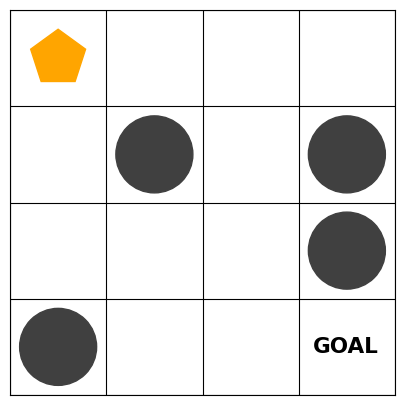

In [30]:
env = gym.make("FrozenLake4x4-v2")
env.render()

In [33]:
pi_right = {state : 1 for state in range(env.prob.shape[0])}
mc_val = mc_prediction(env, pi_right)

If we compared this to the state values computed by the policy evaluation algorithm, we would notice that we merely got an approximation. Still, the results look good:

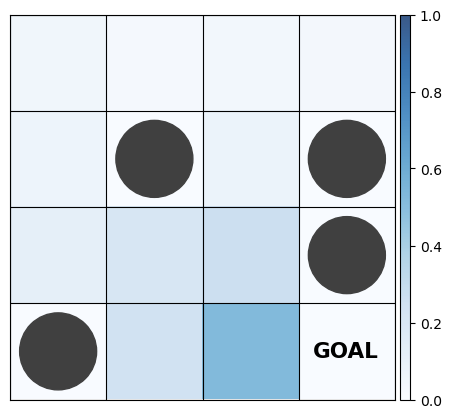

In [34]:
env.render(values=mc_val)

### Monte Carlo Estimation of Action Values

Without a model of the environment, state-values are not sufficient to determine a policy (how would we know which action to take in each state?). Hence, we must estimate the action-value function $q_{\pi}(s)$ in order to tackle the control problem. Fortunately, MC estimation of action values is basically the same as for state values. We just need to consider visits to **state-action pairs** instead of states (a state-action pair $s,a$ means being in state $s$ and taking action $a$). The first-visit MC method averages the returns following the first visit per episode of a state-action pair, while the every-visit MC method averages over all visits of a state-action pair. 

$$N(S_t, A_t) \leftarrow N(S_t, A_t) + 1$$

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \dfrac{1}{N(S_t, A_t)} (G_t - Q(S_t, A_t))$$

Both methods are guaranteed to converge to the true expected values as the number of visits to each state-action pair goes to infinity. This poses an important challenge, though. It is not guaranteed (unlikely in fact) that the sampled trajectories cover the entire state and action space, yet we need solid estimates of *all* alternatives in order to know which action is the best in each state. Put differently, we **need to gather experience with all available states and actions**, and not only the ones we visit when following our current policy. The good news is that this is not uncharted territory for us. With the $\epsilon$-greedy action selection strategy we have already introduced a simple and yet very useful method to balance our need for both exploration and exploitation. Let's see how it fits into MC control.

## Monte Carlo Control

Recall the pattern of **generalized policy iteration (GPI)** that we introduced in the last chapter on DP methods. GPI consists of two processes: estimating the value function of a given policy (policy evaluation) and improving the policy by making it greedy with respect to the value function (policy improvement). Alternating between these steps ultimately leads to the optimal policy and the optimal value function. 

How can we use this pattern with MC methods where we don't have complete knowledge of the MDP? As we already mentioned above, there are two changes to make. First, we need to estimate action-values instead of state-values since we otherwise wouldn't know which action we should take in each state. We therefore use **first-visit MC prediction of action values in the policy evaluation phase**. Second, we need to explore the entire state and action space since we otherwise wouldn't know whether there are more valuable states and actions than those that we visit under our current policy. This is why we use the **$\epsilon$-greedy strategy to select actions in the policy improvement phase**. We still take the greedy action most of time, but we also satisfy our need for exploration by randomly choosing an action with small probability $\epsilon$. Note that we should slowly **decay $\epsilon$ towards zero** in order to make sure that the algorithm can converge to a greedy policy in the end. This is called being **Greedy in the Limit with Infinite Exploration (GLIE)** and guarantees convergence to the optimal policy. 

In [35]:
def sample_trajectory(env, pi, q, epsilon, max_steps=200):
    done = False
    trajectory = []
    
    while not done:
        state = env.reset()
        
        for t in count():
            action = pi(state, q, epsilon)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    
    return np.array(trajectory, dtype="object")

In [36]:
#| code-fold: show

def mc_control(env, 
               gamma=1., 
               n_episodes=1000, 
               max_steps=200, 
               first_visit=True, 
               start_eps=1., 
               min_eps=0.1, 
               eps_decay_ratio=0.75, 
               start_alpha=0.5, 
               min_alpha=0.01, 
               alpha_decay_ratio=0.5):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    discounts = np.power(gamma, np.arange(max_steps))
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    epsilons = decay(eps_decay_ratio, start_eps, min_eps, n_episodes)
    
    q = np.zeros((n_states, n_actions))
    
    pi = lambda state, q, epsilon: np.argmax(q[state]) if np.random.random() > epsilon else np.random.randint(len(q[state]))
    
    for ep in range(n_episodes):
        trajectory = sample_trajectory(env, pi, q, epsilons[ep], max_steps)
        visited = np.zeros((n_states, n_actions), dtype="bool")
        
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if first_visit and visited[state][action]:
                continue
            visited[state][action] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            q[state][action] += alphas[ep] * (G - q[state][action])
    
    value = np.max(q, axis=1)
    pi = np.argmax(q, axis=1)
    
    return value, pi

In [40]:
env = gym.make("FrozenLake4x4-v2")

In [49]:
mc_val, mc_pi = mc_control(env, gamma=1., n_episodes=100000, max_steps=200, first_visit=True)

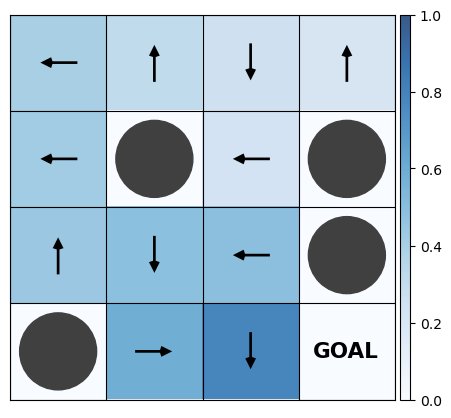

In [50]:
env.render(values=mc_val, policy=mc_pi)

As we can see MC methods can attain optimal behavior in an environment without having prior knowledge of its dynamics. This is why MC control is called a model-free algorithm; it optimizes the value function of an unknown MDP by learning from interaction with the environment.

In the next post, we'll look at temporal difference (TD) learning methods which don't even require complete sequences to solve the RL problem.